In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

In [92]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [7]:
data = pd.read_csv("../data/text.csv", usecols=['text', 'label'])

In [8]:
data

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: 
1. sadness (0)
2. joy (1)
3. love (2)
4. anger (3)
5. fear (4)
6. surprise (5)

/Users/adityasingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='label'>

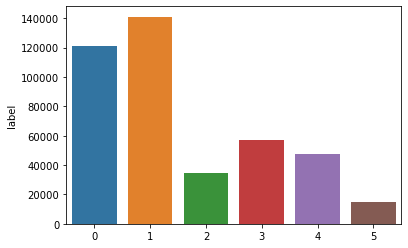

In [13]:
sns.barplot(data.label.value_counts().index, data.label.value_counts())

In [145]:
# checking all the distince characters in the tweet
unique_chars = ' '.join(data.text.tolist())
unique_chars = sorted((list(set(allText))))
print(unique_chars)

# we can conclude that the data is already clean, so we dont need to do any preprocessing

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [216]:
def text_preprocessing(text):
    text = text.replace('ive', 'i have')
    text = text.replace('dont', 'do not')
    text = text.replace('cant', 'can not')
    text = text.replace('didnt', 'did not')
    text = text.replace('wasnt', 'was not')
    text = text.replace('thats', 'that is')
    text = text.replace('wont', 'would not')
    text = text.replace('havent', 'have not')
    text = text.replace('testimoney', 'testimony')
    text = text.replace('doesnt', 'does not')
    text = text.replace('youre', 'you are')
    text = text.replace('positi', 'positive')
    text = text.replace('couldnt', 'could not')
    text = text.replace('theres', 'there is')
    text = text.replace('isnt', 'is not')
    text = text.replace('wouldnt', 'would not')
    listOfWords = text.split()
    for i in range(len(listOfWords)):
        if listOfWords[i]=='havely' or listOfWords[i]=='haved':
            listOfWords[i] = listOfWords[i][2:]
    sentence = ''
    for i in range(len(listOfWords)-1):
        if listOfWords[i+1] == 'vely' or listOfWords[i+1] == 'ved':
            sentence = sentence + ' ' + listOfWords[i] + listOfWords[i+1]
            i = i+1
        else:
            sentence = sentence + ' ' + listOfWords[i]
    text = sentence
    
    return text

In [217]:
data.text = data.text.progress_apply(text_preprocessing)

100%|████████████████████████████████| 416809/416809 [00:04<00:00, 83547.19it/s]


In [218]:
tokenizer = model.tokenizer
embedding_vocab = tokenizer.vocab

In [219]:
my_data_vocab = {}
for x in tqdm(data.text.tolist()):
    words = x.split()
    for word in words:
        try:
            my_data_vocab[word] += 1
        except:
            my_data_vocab[word] = 1
            
my_data_vocab = sorted(my_data_vocab.items(), key=operator.itemgetter(1))[::-1]

100%|███████████████████████████████| 416809/416809 [00:01<00:00, 213722.43it/s]


In [220]:
my_data_vocab[:10][0]

('i', 592577)

In [221]:
def check_coverage(vocab):
    total_unique = len(my_data_vocab)*1.0
    a = {}
    oov = {}
    k = 0
    j = 0
    for word in tqdm(vocab):
        try:
            a[word[0]] = embedding_vocab[word[0]]
            k += word[1]
        except KeyError:
            oov[word[0]] = word[1]
            j += word[1]
    print(f"Total percentage covered for unique words is: {(len(a)/total_unique)*100.0}")
    print(f"Total percentage covered for entire text is: {(k*1.0)*100.0/(k+j)}")
    oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return oov

In [212]:
oov = check_coverage(my_data_vocab)

100%|█████████████████████████████████| 60615/60615 [00:00<00:00, 959720.87it/s]

Total percentage covered for unique words is: 30.645879732739424
Total percentage covered for entire text is: 96.78454303514134


In [222]:
oov = check_coverage(my_data_vocab)

100%|█████████████████████████████████| 58694/58694 [00:00<00:00, 928170.35it/s]

Total percentage covered for unique words is: 31.42910689337922
Total percentage covered for entire text is: 96.78884651250603


In [223]:
oov[:10]

[('ved', 6277),
 ('vedvedved', 2210),
 ('vedvedvedvedved', 1941),
 ('haves', 1606),
 ('creati', 1148),
 ('hes', 1000),
 ('insecure', 909),
 ('apprehensi', 904),
 ('resentful', 903),
 ('producti', 839)]

In [224]:
tweets = data.text.tolist()
for i, tweet in enumerate(tweets):
    if 'producti' in tweet.split() and i>0:
        print(i)
        print(tweet)
        break

148
 i feel agitated and can not think of anything producti have to do all i can really do is lay on my bed not getting a blink


In [227]:
encoded_data = []
for sentence in tqdm(data.text.tolist()):
    encoded_data.append(tokenizer.encode(sentence))

100%|█████████████████████████████████| 416809/416809 [01:22<00:00, 5049.29it/s]


In [231]:
length_data = [len(x) for x in encoded_data]
maxlen = max(length_data)

In [239]:
maxlen

183

<AxesSubplot:ylabel='Count'>

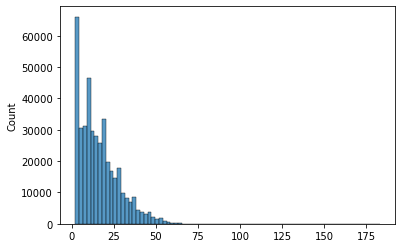

In [237]:
sns.histplot(length_data, bins=80)

In [248]:
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [246]:
padded_data = pad_sequences(encoded_data, maxlen=185, padding='post')
labels = to_categorical(data.label)

In [247]:
labels

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [270]:
padded_np = np.array(padded_data)
print(f"train_data shape: {padded_np.shape}, train_label shape: {labels.shape}")
print(f"train_data max embedding: {np.max(padded_np)}")

train_data shape: (416809, 185), train_label shape: (416809, 6)
train_data max embedding: 29611


In [266]:
basic_nn_model = Sequential()
basic_nn_model.add(Dense(1024, activation='relu', input_shape=(padded_np.shape[1],)))
basic_nn_model.add(Dropout(0.3))
basic_nn_model.add(Dense(512, activation='relu'))
basic_nn_model.add(Dense(64, activation='relu'))
basic_nn_model.add(Dense(6, activation='softmax'))

In [267]:
basic_nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [268]:
basic_nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1024)              190464    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dense_15 (Dense)            (None, 64)                32832     
                                                                 
 dense_16 (Dense)            (None, 6)                 390       
                                                                 
Total params: 748486 (2.86 MB)
Trainable params: 748486 (2.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [269]:
history = basic_nn_model.fit(padded_np, labels, epochs=5, batch_size=16, validation_split=0.3)

Epoch 1/5
18236/18236 [==============================] - 153s 8ms/step - loss: 2.5653 - acc: 0.3380 - val_loss: 1.5736 - val_acc: 0.3384
Epoch 2/5
18236/18236 [==============================] - 158s 9ms/step - loss: 1.5725 - acc: 0.3385 - val_loss: 1.5737 - val_acc: 0.3384
Epoch 3/5
18236/18236 [==============================] - 155s 8ms/step - loss: 1.5725 - acc: 0.3385 - val_loss: 1.5736 - val_acc: 0.3384
Epoch 4/5
18236/18236 [==============================] - 160s 9ms/step - loss: 1.5725 - acc: 0.3385 - val_loss: 1.5736 - val_acc: 0.3384
Epoch 5/5
18236/18236 [==============================] - 159s 9ms/step - loss: 1.5724 - acc: 0.3385 - val_loss: 1.5739 - val_acc: 0.3384


In [280]:
from tensorflow.keras.layers import GRU, Bidirectional, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
UNITS = 256

lstm_model_basic = Sequential()
lstm_model_basic.add(Embedding(100207, 15, input_shape=(padded_np.shape[1], )))
lstm_model_basic.add(Bidirectional(GRU(units=UNITS, return_sequences=True)))
lstm_model_basic.add(Flatten())
lstm_model_basic.add(Dense(128, activation='relu'))
lstm_model_basic.add(Dense(32, activation='relu'))
lstm_model_basic.add(Dense(8, activation='relu'))
lstm_model_basic.add(Dense(6, activation='softmax'))

In [281]:
adam = Adam(learning_rate=1e-5)
lstm_model_basic.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = lstm_model_basic.fit(padded_np, labels, epochs=5, batch_size=32, validation_split=0.3)